# T-100 Market Structure + Merger-ready Dataset + DB1B Collection

In [2]:
import pandas as pd

## Step 1 — Load cleaned T-100 and build time variables

In [10]:
import pandas as pd
import numpy as np

t100_path = r"D:\MERGER IMPACT ANALYSIS\t100_processed\t100_citypair_quarter_clean.parquet"
df = pd.read_parquet(t100_path)

# quarter id as an integer timeline
df["qtr_id"] = df["YEAR"].astype(int) * 4 + df["quarter"].astype(int)

# Event quarter = 2013Q4 (merger closes Dec 9, 2013)
event_qtr_id = 2013 * 4 + 4

# Event-time index (t=0 at 2013Q4)
df["t"] = df["qtr_id"] - event_qtr_id

# Keep the event quarter, but DO NOT treat it as post
df["event_q"] = (df["qtr_id"] == event_qtr_id).astype(int)

# Define post starting 2014Q1 (clean post period)
df["post"] = (df["qtr_id"] >= (2014 * 4 + 1)).astype(int)

# (Optional) If you want an explicit "pre" indicator too:
df["pre"] = (df["qtr_id"] <= (2013 * 4 + 3)).astype(int)

# Quick sanity check: event quarter should be t==0, event_q==1, post==0
chk = df.loc[df["event_q"] == 1, ["YEAR", "quarter", "t", "event_q", "post"]].drop_duplicates()
print(chk)


         YEAR  quarter  t  event_q  post
1333592  2013        4  0        1     0


## Step 2 — Create pre-merger presence and treatment flags (route-level)

In [11]:
MERGERS = {"AA", "US"}

# presence per market-quarter-carrier already implicit; we need market-level pre presence
pre = df.loc[df["post"] == 0].copy()

pre_presence = (
    pre.assign(present = (pre["seats"] > 0) | (pre["dep"] > 0) | (pre["pax"] > 0))
       .groupby(["mkt","carrier"], as_index=False)["present"].max()
)

# market-level: was AA present pre? was US present pre?
pre_mkt = (
    pre_presence.query("carrier in @MERGERS")
      .pivot(index="mkt", columns="carrier", values="present")
      .fillna(False)
      .rename(columns={"AA":"AA_pre", "US":"US_pre"})
      .reset_index()
)

pre_mkt["treat_overlap"] = (pre_mkt["AA_pre"] & pre_mkt["US_pre"]).astype(int)
pre_mkt["control_neither"] = (~pre_mkt["AA_pre"] & ~pre_mkt["US_pre"]).astype(int)
pre_mkt["control_one_only"] = ((pre_mkt["AA_pre"] ^ pre_mkt["US_pre"])).astype(int)  # xor

C:\Users\管硕萌\AppData\Local\Temp\ipykernel_10656\2886113535.py:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .fillna(False)


In [12]:
df = df.merge(pre_mkt[["mkt","AA_pre","US_pre","treat_overlap","control_neither","control_one_only"]],
              on="mkt", how="left")
df[["AA_pre","US_pre","treat_overlap"]] = df[["AA_pre","US_pre","treat_overlap"]].fillna(False).astype(int)

C:\Users\管硕萌\AppData\Local\Temp\ipykernel_10656\3728282535.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[["AA_pre","US_pre","treat_overlap"]] = df[["AA_pre","US_pre","treat_overlap"]].fillna(False).astype(int)


## Step 3 — Build market structure measures (HHI, #carriers, shares)

In [13]:
# carrier share by seats (use dep if seats still worries you; but seats is fine after cleaning)
mq = df.groupby(["mkt","qtr_id"], as_index=False)["seats"].sum().rename(columns={"seats":"seats_mq"})
df = df.merge(mq, on=["mkt","qtr_id"], how="left")

df["share_seats"] = np.where(df["seats_mq"] > 0, df["seats"] / df["seats_mq"], 0.0)

hhi = (
    df.groupby(["mkt","qtr_id"], as_index=False)
      .agg(HHI_seats=("share_seats", lambda s: float(np.sum(np.square(s)))),
           n_carriers=("carrier", "nunique"),
           seats_total=("seats", "sum"),
           pax_total=("pax", "sum"),
           dep_total=("dep", "sum"))
)
df_mkt = (
    hhi.merge(pre_mkt[["mkt","treat_overlap","control_neither","control_one_only"]], on="mkt", how="left")
       .merge(df[["mkt","qtr_id","t","post"]].drop_duplicates(), on=["mkt","qtr_id"], how="left")
)

In [5]:
df_mkt.head()

,mkt,qtr_id,HHI_seats,n_carriers,seats_total,pax_total,dep_total,treat_overlap,control_neither,control_one_only,t,post
0,04A_OTZ,8046,1.0,1,8442,1596,72,NaN,NaN,NaN,-10,0
1,04A_OTZ,8047,1.0,1,6398,640,76,NaN,NaN,NaN,-9,0
2,04A_WTK,8046,1.0,1,276,516,12,NaN,NaN,NaN,-10,0
3,05A_FAI,8046,1.0,1,624,216,24,NaN,NaN,NaN,-10,0
4,05A_FAI,8047,1.0,1,2697,1084,80,NaN,NaN,NaN,-9,0


In [6]:
tmp = (df_mkt.groupby(["treat_overlap","t"])["seats_total"].mean().reset_index())
tmp = tmp.loc[tmp["t"] <= -1]  # pre only
tmp.head()

,treat_overlap,t,seats_total
0,0.0,-19,10267.368502
1,0.0,-18,28294.018713
2,0.0,-17,49909.767601
3,0.0,-16,70236.752201
4,0.0,-15,86372.459053


In [3]:
file_path='DB1B_raw/Origin_and_Destination_Survey_DB1BMarket_2010_3.csv'
db1b3q=pd.read_csv(file_path)
db1b3q.head()

C:\Users\管硕萌\AppData\Local\Temp\ipykernel_10656\2507372808.py:2: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  db1b3q=pd.read_csv(file_path)


,ItinID,MktID,MktCoupons,Year,Quarter,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,Origin,OriginCountry,...,BulkFare,Passengers,MktFare,MktDistance,MktDistanceGroup,MktMilesFlown,NonStopMiles,ItinGeoType,MktGeoType,Unnamed: 41
0,201034358324,201037648804,2,2010,3,13296,1329603,30721,MHT,US,...,0.0,1.0,174.0,600.0,2,600.0,595.0,2,2,NaN
1,201034358325,201037648805,2,2010,3,14574,1457401,34574,ROA,US,...,0.0,1.0,174.0,600.0,2,600.0,595.0,2,2,NaN
2,201034358325,201037648806,2,2010,3,13296,1329603,30721,MHT,US,...,0.0,1.0,174.0,600.0,2,600.0,595.0,2,2,NaN
3,201034358326,201037648807,2,2010,3,14574,1457401,34574,ROA,US,...,0.0,1.0,144.0,600.0,2,600.0,595.0,2,2,NaN
4,201034358326,201037648808,2,2010,3,13296,1329603,30721,MHT,US,...,0.0,1.0,144.0,600.0,2,600.0,595.0,2,2,NaN


In [4]:
db1b3q.columns

Index(['ItinID', 'MktID', 'MktCoupons', 'Year', 'Quarter', 'OriginAirportID',
       'OriginAirportSeqID', 'OriginCityMarketID', 'Origin', 'OriginCountry',
       'OriginStateFips', 'OriginState', 'OriginStateName', 'OriginWac',
       'DestAirportID', 'DestAirportSeqID', 'DestCityMarketID', 'Dest',
       'DestCountry', 'DestStateFips', 'DestState', 'DestStateName', 'DestWac',
       'AirportGroup', 'WacGroup', 'TkCarrierChange', 'TkCarrierGroup',
       'OpCarrierChange', 'OpCarrierGroup', 'RPCarrier', 'TkCarrier',
       'OpCarrier', 'BulkFare', 'Passengers', 'MktFare', 'MktDistance',
       'MktDistanceGroup', 'MktMilesFlown', 'NonStopMiles', 'ItinGeoType',
       'MktGeoType', 'Unnamed: 41'],
      dtype='object')

In [5]:
dfp = pd.read_parquet(r"D:\MERGER IMPACT ANALYSIS\db1b_processed\db1b_market_quarter.parquet")
print(dfp.head())
print("Years:", dfp.YEAR.min(), dfp.YEAR.max())
print("quarters unique:", sorted(dfp.quarter.unique()))
print("any pax<=0:", (dfp.pax_db1b <= 0).mean())
print("any fare<=0:", (dfp.fare_mean <= 0).mean())

           mkt  qtr_id  YEAR  quarter  pax_db1b  n_rows  fare_mean
0  30009_30070    8041  2010        1       4.0       4   253.2475
1  30009_30073    8041  2010        1       5.0       5   489.4020
2  30009_30107    8041  2010        1       2.0       2   419.0350
3  30009_30113    8041  2010        1       2.0       2   387.9800
4  30009_30140    8041  2010        1       2.0       2   600.6200
Years: 2010 2016
quarters unique: [1, 2, 3, 4]
any pax<=0: 0.0
any fare<=0: 0.0038385033451363896


In [52]:
db1b_path = r"D:\MERGER IMPACT ANALYSIS\db1b_processed\db1b_market_quarter.parquet"
db1b = pd.read_parquet(db1b_path)

In [53]:
t100_path = r"D:\MERGER IMPACT ANALYSIS\t100_processed\t100_citypair_quarter_clean.parquet"
t100 = pd.read_parquet(t100_path)

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\MERGER IMPACT ANALYSIS\\t100_processed\\t100_citypair_quarter_clean.parquet'

In [16]:
df_mkt = df_mkt.merge(
    df[["mkt","qtr_id","YEAR","quarter"]].drop_duplicates(),
    on=["mkt","qtr_id"],
    how="left"
)

## From here

In [1]:
import pandas as pd
import numpy as np

t100_mkt_path = r"D:\MERGER IMPACT ANALYSIS\t100_processed\t100_mktq_citymarket.parquet"
t100_mkt = pd.read_parquet(t100_mkt_path)

# Ensure key types
t100_mkt["mkt"] = t100_mkt["mkt"].astype(str)
t100_mkt["qtr_id"] = t100_mkt["qtr_id"].astype(int)

# (Optional) if YEAR/quarter not present for some reason, recreate:
if "YEAR" not in t100_mkt.columns or "quarter" not in t100_mkt.columns:
    t100_mkt["YEAR"] = ((t100_mkt["qtr_id"] - 1)//4).astype(int)
    t100_mkt["quarter"] = (((t100_mkt["qtr_id"] - 1)%4)+1).astype(int)

In [2]:
db1b_path = r"D:\MERGER IMPACT ANALYSIS\db1b_processed\db1b_market_quarter.parquet"
db1b = pd.read_parquet(db1b_path)

db1b["mkt"] = db1b["mkt"].astype(str)
db1b["qtr_id"] = db1b["qtr_id"].astype(int)

panel = db1b.merge(t100_mkt, on=["mkt","qtr_id"], how="left", indicator=True)

print("Match rate:", (panel["_merge"]=="both").mean())
print(panel["_merge"].value_counts())

Match rate: 0.11529003832479329
_merge
left_only     734319
both           95692
right_only         0
Name: count, dtype: int64


In [3]:
import pandas as pd

db1b = pd.read_parquet(r"D:\MERGER IMPACT ANALYSIS\db1b_processed\db1b_market_quarter.parquet")
t100_c = pd.read_parquet(r"D:\MERGER IMPACT ANALYSIS\t100_processed\t100_carrierq_citymarket.parquet")

db1b["mkt"] = db1b["mkt"].astype(str)
t100_c["mkt"] = t100_c["mkt"].astype(str)
db1b["qtr_id"] = db1b["qtr_id"].astype(int)
t100_c["qtr_id"] = t100_c["qtr_id"].astype(int)

panel_c = t100_c.merge(
    db1b[["mkt","qtr_id","fare_mean","pax_db1b","n_rows"]],
    on=["mkt","qtr_id"],
    how="left",
    indicator=True
)

print("Match rate:", (panel_c["_merge"]=="both").mean())
print(panel_c["_merge"].value_counts())

Match rate: 0.3926051551801531
_merge
left_only     384289
both          248395
right_only         0
Name: count, dtype: int64


In [4]:
t100_c["present"] = ((t100_c["seats"] > 0) | (t100_c["dep"] > 0) | (t100_c["pax"] > 0)).astype(int)

In [30]:
t100_c.columns

Index(['mkt', 'qtr_id', 'carrier', 'seats', 'pax', 'dep', 'present'], dtype='object')

In [5]:
import numpy as np
import pandas as pd

df = t100_c.copy()

# 1) Seat share within market-quarter (only where market has positive seats)
mq = (
    df.groupby(["mkt", "qtr_id"], as_index=False)["seats"]
      .sum()
      .rename(columns={"seats": "seats_mq"})
)
df = df.merge(mq, on=["mkt", "qtr_id"], how="left")
df = df[df["seats_mq"] > 0].copy()
df["s_seat"] = df["seats"] / df["seats_mq"]

# (Optional) If you want to require "present==1"
df = df[df["present"] == 1].copy()

out = []

for q, g in df.groupby("qtr_id", sort=True):
    # Pivot: rows=markets, cols=carriers, values=seat share
    S = g.pivot_table(index="mkt", columns="carrier", values="s_seat",
                      aggfunc="sum", fill_value=0.0)

    # 2) Overlap matrix across all markets in quarter q: O = S' S
    O = S.T.to_numpy() @ S.to_numpy()
    carriers = S.columns.to_numpy()

    # 3) Row-sum excluding self: sum_j!=i O_ij
    row_sum_excl_self = O.sum(axis=1) - np.diag(O)
    row_sum_map = pd.Series(row_sum_excl_self, index=carriers, name="row_sum_excl_self")

    # 4) Map back to each carrier-market observation
    gg = g[["mkt", "qtr_id", "carrier", "s_seat"]].drop_duplicates().copy()
    gg = gg.join(row_sum_map, on="carrier")

    # subtract focal-market term: s_im * (1 - s_im)
    gg["mmc_seat"] = gg["row_sum_excl_self"] - gg["s_seat"] * (1.0 - gg["s_seat"])

    out.append(gg[["mkt", "qtr_id", "carrier", "mmc_seat", "s_seat"]])

mmc = pd.concat(out, ignore_index=True)

# -----------------------------
# 5) Lag MMC by 1 quarter (SEQUENTIAL qtr_id CASE)
#   and DROP the old qtr_id after renaming
# -----------------------------

mmc_lag = mmc.copy()
mmc_lag["qtr_id_next"] = mmc_lag["qtr_id"] + 1

# rename qtr_id_next -> qtr_id, and drop the old qtr_id cleanly
mmc_lag = (
    mmc_lag
      .rename(columns={"qtr_id": "qtr_id_old"})
      .rename(columns={"qtr_id_next": "qtr_id", "mmc_seat": "mmc_seat_lag1"})
      .drop(columns=["qtr_id_old"])
      .loc[:, ["mkt", "qtr_id", "carrier", "mmc_seat_lag1"]]
      .drop_duplicates(["mkt", "qtr_id", "carrier"])
)

In [72]:
mmc_lag.head()

,mkt,qtr_id,carrier,mmc_seat_lag1
0,10350_10360,8038,L2,1.936575
1,10360_10360,8038,4Y,15.735013
2,10360_10360,8038,7S,16.984465
3,10360_10360,8038,GV,21.055847
4,10360_16160,8038,H6,45.668593


In [6]:
panel_c = panel_c.merge(
    mmc_lag,
    on=["mkt","qtr_id","carrier"],
    how="left",
    validate="m:1"
)

In [75]:
mmc_lag.head()

,mkt,qtr_id,carrier,mmc_seat_lag1
0,10350_10360,8038,L2,1.936575
1,10360_10360,8038,4Y,15.735013
2,10360_10360,8038,7S,16.984465
3,10360_10360,8038,GV,21.055847
4,10360_16160,8038,H6,45.668593


In [76]:
# Check the EXACT column name (including hidden spaces/characters)
print("Column names:", mmc_lag.columns.tolist())
print("Column name repr:", repr(mmc_lag.columns[3]))  # The 4th column

Column names: ['mkt', 'qtr_id', 'carrier', 'mmc_seat_lag1']
Column name repr: 'mmc_seat_lag1'


In [77]:
# Clean column names (remove leading/trailing spaces)
mmc_lag.columns = mmc_lag.columns.str.strip()

In [78]:
# Ensure exact column name
mmc_lag = mmc_lag.rename(columns={mmc_lag.columns[3]: 'mmc_seat_lag1'})

In [80]:
# Check mmc_lag
print("=== mmc_lag info ===")
print("Shape:", mmc_lag.shape)
print("Columns:", mmc_lag.columns.tolist())
print("Dtypes:\n", mmc_lag.dtypes)
print("\nFirst 3 rows:\n", mmc_lag.head(3))

# Check panel_c (the price panel you're merging into)
print("\n=== panel_c info ===")
print("Shape:", panel_c.shape)
print("Columns:", panel_c.columns.tolist())
print("Dtypes:\n", panel_c.dtypes)

# Check if the merge keys actually exist
print("\n=== Key columns check ===")
print("mmc_lag has 'mkt'?", 'mkt' in mmc_lag.columns)
print("mmc_lag has 'qtr_id'?", 'qtr_id' in mmc_lag.columns)
print("mmc_lag has 'carrier'?", 'carrier' in mmc_lag.columns)
print("panel_c has 'mkt'?", 'mkt' in panel_c.columns)
print("panel_c has 'qtr_id'?", 'qtr_id' in panel_c.columns)
print("panel_c has 'carrier'?", 'carrier' in panel_c.columns)

=== mmc_lag info ===
Shape: (631800, 4)
Columns: ['mkt', 'qtr_id', 'carrier', 'mmc_seat_lag1']
Dtypes:
 mkt               object
qtr_id             int32
carrier           object
mmc_seat_lag1    float64
dtype: object

First 3 rows:
            mkt  qtr_id carrier  mmc_seat_lag1
0  10350_10360    8038      L2       1.936575
1  10360_10360    8038      4Y      15.735013
2  10360_10360    8038      7S      16.984465

=== panel_c info ===
Shape: (632684, 11)
Columns: ['mkt', 'qtr_id', 'carrier', 'seats', 'pax', 'dep', 'fare_mean', 'pax_db1b', 'n_rows', '_merge', 'mmc_seat_lag1']
Dtypes:
 mkt                object
qtr_id              int32
carrier            object
seats               int64
pax                 int64
dep                 int64
fare_mean         float64
pax_db1b          float64
n_rows            float64
_merge           category
mmc_seat_lag1     float64
dtype: object

=== Key columns check ===
mmc_lag has 'mkt'? True
mmc_lag has 'qtr_id'? True
mmc_lag has 'carrier'? True
pa

In [7]:
# Assumptions:
# - price_panel has at least: ['mkt','qtr_id','carrier', <your price column>]
# - t100_c has: ['mkt','qtr_id','carrier','seats','pax','dep','present']
# - mmc_lag1 has: ['mkt','qtr_id','carrier','mmc_seat_lag1']  (already built)

# ----------------------------
# STEP 4: Build regression-ready panel
# ----------------------------

def build_reg_panel(panel_c: pd.DataFrame,
                    t100_c: pd.DataFrame,
                    mmc_lag: pd.DataFrame,
                    price_col: str = "fare_mean",
                    keep_present_current_qtr: bool = True,
                    mmc_missing_option: str = "drop"  # "drop" or "zero_with_flag"
                   ) -> pd.DataFrame:
    """
    Returns a regression-ready panel with:
      - mmc_seat_lag1 merged
      - market-quarter totals: seats_mq, pax_mq, dep_mq
      - carrier market shares: s_seat, s_pax, s_dep
      - concentration: hhi_seat (market-quarter)
      - missing MMC handling per mmc_missing_option
    """

    # --- 0) defensive copies + basic columns ---
    pp = panel_c.copy()
    tc = t100_c.copy()
    ml = mmc_lag.copy()
    print("DEBUG ml columns:", ml.columns.tolist()[:20])
    print("DEBUG ml head:\n", ml.head())

    required_pp = {"mkt","qtr_id","carrier", "fare_mean"}
    required_tc = {"mkt","qtr_id","carrier","seats","pax","dep","present"}
    required_ml = {"mkt","qtr_id","carrier","mmc_seat_lag1"}

    missing_pp = required_pp - set(pp.columns)
    missing_tc = required_tc - set(tc.columns)
    missing_ml = required_ml - set(ml.columns)

    if missing_pp:
        raise ValueError(f"price_panel missing columns: {missing_pp}")
    if missing_tc:
        raise ValueError(f"t100_c missing columns: {missing_tc}")
    if missing_ml:
        raise ValueError(f"mmc_lag1 missing columns: {missing_ml}")

    # --- 1) enforce uniqueness in price panel keys ---
    key = ["mkt","qtr_id","carrier"]
    if pp.duplicated(key).any():
        # keep first but it's better to fix upstream; raising is safer
        dup_n = pp.duplicated(key).sum()
        raise ValueError(f"price_panel has {dup_n} duplicated key rows on {key}. Fix upstream before proceeding.")

    # --- 2) build market-quarter totals from T-100 (current quarter) ---
    mq_tot = (tc.groupby(["mkt","qtr_id"], as_index=False)
                .agg(seats_mq=("seats","sum"),
                     pax_mq=("pax","sum"),
                     dep_mq=("dep","sum")))

    # --- 3) carrier-level shares within market-quarter (current quarter) ---
    shares = tc.merge(mq_tot, on=["mkt","qtr_id"], how="left")

    # avoid divide-by-zero
    for v in ["seats","pax","dep"]:
        denom = f"{v}_mq"
        shares[f"s_{v}"] = np.where(shares[denom] > 0, shares[v] / shares[denom], np.nan)

    shares = shares[["mkt","qtr_id","carrier","present","seats","pax","dep",
                     "seats_mq","pax_mq","dep_mq","s_seats","s_pax","s_dep"]].copy()

    # --- 4) HHI using seat shares (market-quarter) ---
    # (Use current-quarter shares; for robustness you can compute pax HHI too)
    hhi = (shares.dropna(subset=["s_seats"])
                 .groupby(["mkt","qtr_id"], as_index=False)
                 .agg(hhi_seat=("s_seats", lambda x: float(np.sum(np.square(x)))),
                      n_carriers=("carrier","nunique")))

    # --- 5) merge everything into price panel ---
    reg = (pp
           .merge(ml, on=key, how="left", validate="1:1")
           .merge(shares, on=key, how="left", validate="1:1")
           .merge(hhi, on=["mkt","qtr_id"], how="left", validate="m:1"))

    # --- 6) optionally restrict to carriers present in current quarter ---
    if keep_present_current_qtr:
        reg = reg[reg["present"] == 1].copy()

    # --- 7) handle missing MMC ---
    reg["mmc_missing"] = reg["mmc_seat_lag1"].isna().astype(int)

    if mmc_missing_option == "drop":
        reg = reg.dropna(subset=["mmc_seat_lag1"]).copy()
    elif mmc_missing_option == "zero_with_flag":
        reg["mmc_seat_lag1"] = reg["mmc_seat_lag1"].fillna(0.0)
    else:
        raise ValueError("mmc_missing_option must be 'drop' or 'zero_with_flag'")

    # --- 8) light cleanup helpers ---
    # log market size controls (optional but common)
    reg["ln_seats_mq"] = np.log(reg["seats_mq"].replace({0: np.nan}))
    reg["ln_pax_mq"] = np.log(reg["pax_mq"].replace({0: np.nan}))

    # rename share columns to friendlier names
    reg = reg.rename(columns={"s_seats":"s_seat", "s_pax":"s_pax", "s_dep":"s_dep"})

    return reg


# ----------------------------
# USAGE EXAMPLES
# ----------------------------
# Remove mmc_seat_lag1 if it exists in panel_c
if 'mmc_seat_lag1' in panel_c.columns:
    panel_c = panel_c.drop(columns=['mmc_seat_lag1'])
# Option A (cleanest): keep only obs with defined lagged MMC
reg_panel_drop = build_reg_panel(
    panel_c=panel_c,
    t100_c=t100_c,
    mmc_lag=mmc_lag,
    price_col="fare_mean",                 # <-- change if your column name differs
    keep_present_current_qtr=True,
    mmc_missing_option="drop"
)

# Option B: keep all, set missing MMC to 0 and include mmc_missing in regression
reg_panel_zero = build_reg_panel(
    panel_c=panel_c,
    t100_c=t100_c,
    mmc_lag=mmc_lag,
    price_col="fare_mean",
    keep_present_current_qtr=True,
    mmc_missing_option="zero_with_flag"
)

# Quick audits
print("Drop option rows:", len(reg_panel_drop), "Missing MMC rate:", reg_panel_drop["mmc_missing"].mean())
print("Zero option rows:", len(reg_panel_zero), "Missing MMC rate:", reg_panel_zero["mmc_missing"].mean())
print(reg_panel_drop[["mmc_seat_lag1","s_seat","hhi_seat","seats_mq"]].describe())


DEBUG ml columns: ['mkt', 'qtr_id', 'carrier', 'mmc_seat_lag1']
DEBUG ml head:
            mkt  qtr_id carrier  mmc_seat_lag1
0  10350_10360    8038      L2       1.936575
1  10360_10360    8038      4Y      15.735013
2  10360_10360    8038      7S      16.984465
3  10360_10360    8038      GV      21.055847
4  10360_16160    8038      H6      45.668593
DEBUG ml columns: ['mkt', 'qtr_id', 'carrier', 'mmc_seat_lag1']
DEBUG ml head:
            mkt  qtr_id carrier  mmc_seat_lag1
0  10350_10360    8038      L2       1.936575
1  10360_10360    8038      4Y      15.735013
2  10360_10360    8038      7S      16.984465
3  10360_10360    8038      GV      21.055847
4  10360_16160    8038      H6      45.668593
Drop option rows: 356045 Missing MMC rate: 0.0
Zero option rows: 632684 Missing MMC rate: 0.43724671399940573
       mmc_seat_lag1         s_seat       hhi_seat      seats_mq
count   3.560450e+05  355933.000000  355933.000000  3.560450e+05
mean    4.553547e+01       0.459216       0.6046

In [8]:
import numpy as np
import pandas as pd

df = t100_c.copy()

# 1) seat share within market-quarter
mq = (df.groupby(["mkt","qtr_id"], as_index=False)["seats"]
        .sum()
        .rename(columns={"seats":"seats_mq"}))
df = df.merge(mq, on=["mkt","qtr_id"], how="left")
df = df[df["seats_mq"] > 0].copy()

df["s_seat"] = df["seats"] / df["seats_mq"]

# optional presence restriction (recommended)
df = df[df["present"] == 1].copy()

out = []

for q, g in df.groupby("qtr_id", sort=True):

    # S: markets x carriers, entries are seat shares s_{i,m,t}
    S = g.pivot_table(index="mkt", columns="carrier", values="s_seat",
                      aggfunc="sum", fill_value=0.0)

    V = S.to_numpy()                # (M x C)
    carriers = S.columns.to_numpy()
    mkts = S.index.to_numpy()

    # O = S' S = overlap across ALL markets: O_ij = sum_k s_{i,k}s_{j,k}
    O = V.T @ V                      # (C x C)
    diagO = np.diag(O)               # (C,)

    # hhi_m = sum_j s_{j,m}^2  (per market m)
    hhi = (V**2).sum(axis=1)         # (M,)

    # For each market m, we need (O @ v_m)' for all carriers
    # Stack all markets at once: A = V @ O.T gives row m = (O @ v_m)'.
    A = V @ O.T                      # (M x C)

    # Weighted MMC excluding self and excluding focal market:
    # WMMC_{i,m} = (O v_m)_i - v_i*O_ii - v_i*(HHI_m - v_i^2)
    W = A - (V * diagO[None, :]) - (V * (hhi[:, None] - V**2))  # (M x C)

    # keep only carriers actually present in that market-quarter (share>0)
    m_idx, c_idx = np.where(V > 0)
    tmp = pd.DataFrame({
        "mkt": mkts[m_idx],
        "qtr_id": q,
        "carrier": carriers[c_idx],
        "wmmc_seat": W[m_idx, c_idx],
        "s_seat": V[m_idx, c_idx],
        "hhi_seat": hhi[m_idx],
    })

    out.append(tmp)

wmmc = pd.concat(out, ignore_index=True)

# tiny numeric dust cleanup (optional)
wmmc.loc[wmmc["wmmc_seat"].abs() < 1e-12, "wmmc_seat"] = 0.0

# -----------------------------
# Lag by 1 quarter (SEQUENTIAL qtr_id CASE)
# -----------------------------
wmmc_lag = wmmc.copy()
wmmc_lag["qtr_id_next"] = wmmc_lag["qtr_id"] + 1

wmmc_lag = (
    wmmc_lag
      .rename(columns={"qtr_id": "qtr_id_old"})
      .rename(columns={"qtr_id_next": "qtr_id", "wmmc_seat": "wmmc_seat_lag1"})
      .drop(columns=["qtr_id_old"])
      .loc[:, ["mkt","qtr_id","carrier","wmmc_seat_lag1"]]
      .drop_duplicates(["mkt","qtr_id","carrier"])
)

In [9]:
panel_c = panel_c.loc[:, ~panel_c.columns.duplicated()].copy()  # avoid duplicate-label landmines

panel_c = panel_c.merge(
    wmmc_lag,
    on=["mkt","qtr_id","carrier"],
    how="left",
    validate="m:1"
)

In [10]:
wmmc["wmmc_seat"].describe()
(panel_c["wmmc_seat_lag1"].isna().mean(),
 panel_c.groupby("qtr_id")["wmmc_seat_lag1"].apply(lambda s: s.isna().mean()).head())

(0.43799906430382307,
 qtr_id
 8037    1.000000
 8038    0.459759
 8039    0.389751
 8040    0.447436
 8041    0.411983
 Name: wmmc_seat_lag1, dtype: float64)

In [14]:
import sys
!{sys.executable} -m pip install -U --no-cache-dir linearmodels

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.5 MB 7.9 MB/s eta 0:00:01
   --------------- ------------------------ 0.6/1.5 MB 6.1 MB/s eta 0:00:01
   ----------------------- ---------------- 0.9/1.5 MB 7.0 MB/s eta 0:00:01
   ---------------------------------- ----- 1.3/1.5 MB 7.4 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 8.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/117.3 kB ? eta -:--:--
   ---------------------------------------- 117.3/117.3 kB ? eta 0:00:00
   ---------------------------------------- 0.0/430.8 kB ? eta -:--:--
   --------------------------------------- 430.8/430.8 kB 13.1 MB/s eta 0:00:00


In [13]:
import sys
!{sys.executable} -m pip --version
!{sys.executable} -m pip show linearmodels

pip 24.0 from e:\Python\Lib\site-packages\pip (python 3.12)



In [15]:
from linearmodels.panel import PanelOLS

In [17]:
panel_c.columns

Index(['mkt', 'qtr_id', 'carrier', 'seats', 'pax', 'dep', 'fare_mean',
       'pax_db1b', 'n_rows', '_merge', 'wmmc_seat_lag1'],
      dtype='object')

In [18]:
presence = t100_c[["mkt", "qtr_id", "carrier", "present"]].drop_duplicates()

In [19]:
panel_c = panel_c.merge(
    presence,
    on=["mkt", "qtr_id", "carrier"],
    how="left",
    validate="m:1"
)

In [20]:
panel_c["present"].isna().mean()
panel_c["present"].value_counts(dropna=False)

present
1    632684
Name: count, dtype: int64

In [21]:
# STEP 5: Regressions using wmmc_seat_lag1 (and optionally mmc_seat_lag1 as robustness)

import numpy as np
import pandas as pd
from linearmodels.panel import PanelOLS

# ----------------------------
# 0) Build analysis datasets
# ----------------------------

# Start from your merged panel that now contains wmmc_seat_lag1
df = panel_c.copy()

# Typical restrictions (adjust if you prefer)
if "_merge" in df.columns:
    df = df[df["_merge"] == "both"].copy()

df = df[df["present"] == 1].copy()
df = df[(df["fare_mean"] > 0)].copy()

# If seats_mq exists, drop zero market-size rows (recommended)
if "seats_mq" in df.columns:
    df = df[df["seats_mq"] > 0].copy()

# Outcome
df["ln_fare"] = np.log(df["fare_mean"])

# Controls (use what you actually created in Step 4)
controls = []
for c in ["ln_seats_mq", "hhi_seat", "s_seat"]:
    if c in df.columns:
        controls.append(c)

# ----------------------------
# 1) MAIN SPEC: Drop missing wmmc (clean)
# ----------------------------
df_main = df.dropna(subset=["wmmc_seat_lag1"]).copy()

# Create carrier×market entity id for FE
df_main["im"] = df_main["carrier"].astype(str) + "___" + df_main["mkt"].astype(str)

# Set panel index: entity=im, time=qtr_id
df_main = df_main.set_index(["im", "qtr_id"]).sort_index()

Y_main = df_main["ln_fare"]
X_main = df_main[["wmmc_seat_lag1"] + controls].copy()

mod_main = PanelOLS(Y_main, X_main, entity_effects=True, time_effects=True)
res_main = mod_main.fit(cov_type="clustered", cluster_entity=True)  # cluster by carrier×market

print("\n=== MAIN: wmmc_seat_lag1 | carrier×market FE + quarter FE ===")
print(res_main.summary)

# ----------------------------
# 2) ROBUSTNESS: keep missings, set to 0 + include missing flag (optional)
# ----------------------------
df_rob = df.copy()
df_rob["wmmc_missing"] = df_rob["wmmc_seat_lag1"].isna().astype(int)
df_rob["wmmc_seat_lag1"] = df_rob["wmmc_seat_lag1"].fillna(0.0)

df_rob["im"] = df_rob["carrier"].astype(str) + "___" + df_rob["mkt"].astype(str)
df_rob = df_rob.set_index(["im", "qtr_id"]).sort_index()

Y_rob = df_rob["ln_fare"]
X_rob = df_rob[["wmmc_seat_lag1", "wmmc_missing"] + controls].copy()

mod_rob = PanelOLS(Y_rob, X_rob, entity_effects=True, time_effects=True)
res_rob = mod_rob.fit(cov_type="clustered", cluster_entity=True)

print("\n=== ROBUST: wmmc_seat_lag1 (0-filled) + wmmc_missing | carrier×market FE + quarter FE ===")
print(res_rob.summary)

# ----------------------------
# 3) OPTIONAL: Compare against your unweighted MMC (if you merged mmc_seat_lag1 too)
# ----------------------------
if "mmc_seat_lag1" in df.columns:
    df_cmp = df.dropna(subset=["mmc_seat_lag1"]).copy()
    df_cmp["im"] = df_cmp["carrier"].astype(str) + "___" + df_cmp["mkt"].astype(str)
    df_cmp = df_cmp.set_index(["im", "qtr_id"]).sort_index()

    Y_cmp = df_cmp["ln_fare"]
    X_cmp = df_cmp[["mmc_seat_lag1"] + controls].copy()

    mod_cmp = PanelOLS(Y_cmp, X_cmp, entity_effects=True, time_effects=True)
    res_cmp = mod_cmp.fit(cov_type="clustered", cluster_entity=True)

    print("\n=== COMPARE: mmc_seat_lag1 | carrier×market FE + quarter FE ===")
    print(res_cmp.summary)


=== MAIN: wmmc_seat_lag1 | carrier×market FE + quarter FE ===
                          PanelOLS Estimation Summary                           
Dep. Variable:                ln_fare   R-squared:                     8.496e-06
Estimator:                   PanelOLS   R-squared (Between):             -0.0003
No. Observations:              150494   R-squared (Within):               0.0002
Date:                Thu, Dec 25 2025   R-squared (Overall):             -0.0003
Time:                        20:51:47   Log-likelihood                 6.472e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1.1040
Entities:                       20539   P-value                           0.2934
Avg Obs:                       7.3272   Distribution:                F(1,129933)
Min Obs:                       1.0000                                           
Max Obs:                       22.000   F-stat

In [22]:
tmp = df_main.reset_index()
tmp.groupby("im")["wmmc_seat_lag1"].std().describe()

count    14618.000000
mean         0.926234
std          1.184604
min          0.000000
25%          0.137798
50%          0.509966
75%          1.289920
max         15.549722
Name: wmmc_seat_lag1, dtype: float64

In [23]:
df.columns.tolist()

['mkt',
 'qtr_id',
 'carrier',
 'seats',
 'pax',
 'dep',
 'fare_mean',
 'pax_db1b',
 'n_rows',
 '_merge',
 'wmmc_seat_lag1',
 'present',
 'ln_fare']

In [24]:
import numpy as np
import pandas as pd
from linearmodels.panel import PanelOLS

df = panel_c.copy()

# keep only valid price obs
df = df[(df["_merge"]=="both") & (df["fare_mean"]>0)].copy()
df["ln_fare"] = np.log(df["fare_mean"])

# presence filter (recommended)
df = df[df["present"]==1].copy()

# ---- build market-quarter totals and shares from seats ----
mq = df.groupby(["mkt","qtr_id"], as_index=False)["seats"].sum().rename(columns={"seats":"seats_mq"})
df = df.merge(mq, on=["mkt","qtr_id"], how="left", validate="m:1")

# drop zero-size markets (rare but real in your earlier output)
df = df[df["seats_mq"]>0].copy()

df["s_seat"] = df["seats"] / df["seats_mq"]

hhi = (df.groupby(["mkt","qtr_id"])["s_seat"]
         .apply(lambda x: float(np.sum(np.square(x))))
         .reset_index(name="hhi_seat"))
df = df.merge(hhi, on=["mkt","qtr_id"], how="left", validate="m:1")

# carrier×market FE id
df["im"] = df["carrier"].astype(str) + "___" + df["mkt"].astype(str)

In [25]:
df_main = df.dropna(subset=["wmmc_seat_lag1"]).copy()
df_main = df_main.set_index(["im","qtr_id"]).sort_index()

Y = df_main["ln_fare"]
X = df_main[["wmmc_seat_lag1"]]

res = PanelOLS(Y, X, entity_effects=True, time_effects=True).fit(
    cov_type="clustered", cluster_entity=True
)
print(res.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                ln_fare   R-squared:                     8.508e-06
Estimator:                   PanelOLS   R-squared (Between):             -0.0003
No. Observations:              150483   R-squared (Within):               0.0002
Date:                Thu, Dec 25 2025   R-squared (Overall):             -0.0003
Time:                        21:18:45   Log-likelihood                 6.471e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1.1055
Entities:                       20534   P-value                           0.2931
Avg Obs:                       7.3285   Distribution:                F(1,129927)
Min Obs:                       1.0000                                           
Max Obs:                       22.000   F-statistic (robust):             0.4544
                            

In [26]:
df_main = df.reset_index(drop=True)
df_main = df_main.dropna(subset=["wmmc_seat_lag1","hhi_seat"]).copy()
df_main["wmmc_x_hhi"] = df_main["wmmc_seat_lag1"] * df_main["hhi_seat"]

df_main = df_main.set_index(["im","qtr_id"]).sort_index()

Y = df_main["ln_fare"]
X = df_main[["wmmc_seat_lag1","hhi_seat","wmmc_x_hhi"]]

res_int = PanelOLS(Y, X, entity_effects=True, time_effects=True).fit(
    cov_type="clustered", cluster_entity=True
)
print(res_int.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                ln_fare   R-squared:                        0.0022
Estimator:                   PanelOLS   R-squared (Between):              0.0136
No. Observations:              150483   R-squared (Within):               0.0029
Date:                Thu, Dec 25 2025   R-squared (Overall):              0.0123
Time:                        21:19:24   Log-likelihood                 6.487e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      93.348
Entities:                       20534   P-value                           0.0000
Avg Obs:                       7.3285   Distribution:                F(3,129925)
Min Obs:                       1.0000                                           
Max Obs:                       22.000   F-statistic (robust):             28.308
                            

In [27]:
res_int.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
wmmc_seat_lag1,-0.0026,0.0011,-2.2588,0.0239,-0.0048,-0.0003
hhi_seat,0.0612,0.0100,6.1269,0.0000,0.0416,0.0808
wmmc_x_hhi,0.0049,0.0019,2.5324,0.0113,0.0011,0.0087


In [29]:
# ------------------------------------------------------------
# STEP 5 Robustness Pack (PATCHED): market clustering works
#   (1) Unweighted MMC × HHI (if mmc_seat_lag1 exists)
#   (2) Weighted MMC × HHI with entity vs market clustering
#   (3) Weighted MMC × HighHHI indicator with entity vs market clustering
# ------------------------------------------------------------

import numpy as np
import pandas as pd
from linearmodels.panel import PanelOLS

# ----------------------------
# 0) Base prep (uses your columns exactly)
# ----------------------------
df = panel_c.copy()

# keep valid price obs + operating carriers
df = df[(df["_merge"] == "both") & (df["fare_mean"] > 0) & (df["present"] == 1)].copy()
df["ln_fare"] = np.log(df["fare_mean"])

# compute seat-share HHI from seats
mq = (
    df.groupby(["mkt", "qtr_id"], as_index=False)["seats"]
      .sum()
      .rename(columns={"seats": "seats_mq"})
)
df = df.merge(mq, on=["mkt", "qtr_id"], how="left", validate="m:1")

# drop zero-size markets (avoid log/divide issues)
df = df[df["seats_mq"] > 0].copy()

df["s_seat"] = df["seats"] / df["seats_mq"]

hhi = (
    df.groupby(["mkt", "qtr_id"])["s_seat"]
      .apply(lambda x: float(np.sum(np.square(x))))
      .reset_index(name="hhi_seat")
)
df = df.merge(hhi, on=["mkt", "qtr_id"], how="left", validate="m:1")

# FE id: carrier×market
df["im"] = df["carrier"].astype(str) + "___" + df["mkt"].astype(str)

# ----------------------------
# Helper: PanelOLS with correct clustering alignment
# ----------------------------
def run_fe(df_in: pd.DataFrame, y_col: str, x_cols: list[str], cluster: str = "entity"):
    """
    carrier×market FE (entity) + quarter FE (time)
    cluster='entity' clusters by carrier×market
    cluster='market' clusters by market (aligned Series)
    """
    d = df_in.set_index(["im", "qtr_id"]).sort_index()

    Y = d[y_col]
    X = d[x_cols]

    mod = PanelOLS(Y, X, entity_effects=True, time_effects=True)

    if cluster == "entity":
        return mod.fit(cov_type="clustered", cluster_entity=True)
    elif cluster == "market":
        # IMPORTANT: Series aligned to model index
        clusters = d["mkt"]
        return mod.fit(cov_type="clustered", clusters=clusters)
    else:
        raise ValueError("cluster must be 'entity' or 'market'")

# ============================================================
# (1) Unweighted MMC × HHI (optional; only if mmc_seat_lag1 exists)
# ============================================================
if "mmc_seat_lag1" in df.columns:
    df_mmc = df.dropna(subset=["mmc_seat_lag1", "hhi_seat"]).copy()
    df_mmc["mmc_x_hhi"] = df_mmc["mmc_seat_lag1"] * df_mmc["hhi_seat"]

    res_mmc_entity = run_fe(df_mmc, "ln_fare",
                            ["mmc_seat_lag1", "hhi_seat", "mmc_x_hhi"],
                            cluster="entity")
    res_mmc_market = run_fe(df_mmc, "ln_fare",
                            ["mmc_seat_lag1", "hhi_seat", "mmc_x_hhi"],
                            cluster="market")

    print("\n=== (1a) Unweighted MMC × HHI | cluster=entity (im) ===")
    print(res_mmc_entity.summary)
    print("\n=== (1b) Unweighted MMC × HHI | cluster=market ===")
    print(res_mmc_market.summary)
else:
    print("\nSKIP (1): df has no 'mmc_seat_lag1'. Merge it if you want this check.")

# ============================================================
# (2) Weighted MMC × HHI (your main extension)
# ============================================================
df_w = df.dropna(subset=["wmmc_seat_lag1", "hhi_seat"]).copy()
df_w["wmmc_x_hhi"] = df_w["wmmc_seat_lag1"] * df_w["hhi_seat"]

res_w_entity = run_fe(df_w, "ln_fare",
                      ["wmmc_seat_lag1", "hhi_seat", "wmmc_x_hhi"],
                      cluster="entity")
res_w_market = run_fe(df_w, "ln_fare",
                      ["wmmc_seat_lag1", "hhi_seat", "wmmc_x_hhi"],
                      cluster="market")

print("\n=== (2a) WMMC × HHI | cluster=entity (im) ===")
print(res_w_entity.summary)
print("\n=== (2b) WMMC × HHI | cluster=market ===")
print(res_w_market.summary)

# ============================================================
# (3) Discrete heterogeneity: High-HHI indicator
#     ln_fare ~ wmmc + HighHHI + wmmc×HighHHI
# ============================================================
hhi_med = df_w["hhi_seat"].median()
df_w2 = df_w.copy()
df_w2["high_hhi"] = (df_w2["hhi_seat"] >= hhi_med).astype(int)
df_w2["wmmc_x_highhhi"] = df_w2["wmmc_seat_lag1"] * df_w2["high_hhi"]

res_disc_entity = run_fe(df_w2, "ln_fare",
                         ["wmmc_seat_lag1", "high_hhi", "wmmc_x_highhhi"],
                         cluster="entity")
res_disc_market = run_fe(df_w2, "ln_fare",
                         ["wmmc_seat_lag1", "high_hhi", "wmmc_x_highhhi"],
                         cluster="market")

print(f"\nHHI median cutoff used for high_hhi: {hhi_med:.4f}")

print("\n=== (3a) WMMC × HighHHI | cluster=entity (im) ===")
print(res_disc_entity.summary)
print("\n=== (3b) WMMC × HighHHI | cluster=market ===")
print(res_disc_market.summary)


SKIP (1): df has no 'mmc_seat_lag1'. Merge it if you want this check.

=== (2a) WMMC × HHI | cluster=entity (im) ===
                          PanelOLS Estimation Summary                           
Dep. Variable:                ln_fare   R-squared:                        0.0022
Estimator:                   PanelOLS   R-squared (Between):              0.0136
No. Observations:              150483   R-squared (Within):               0.0029
Date:                Thu, Dec 25 2025   R-squared (Overall):              0.0123
Time:                        21:43:54   Log-likelihood                 6.487e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      93.348
Entities:                       20534   P-value                           0.0000
Avg Obs:                       7.3285   Distribution:                F(3,129925)
Min Obs:                       1.0000                                   

In [30]:
# Full parameter table (entity-clustered)
print("\nENTITY-clustered params:")
print(pd.DataFrame({
    "coef": res_w_entity.params,
    "se": res_w_entity.std_errors,
    "t": res_w_entity.tstats,
    "p": res_w_entity.pvalues,
    "ci_low": res_w_entity.conf_int().iloc[:,0],
    "ci_high": res_w_entity.conf_int().iloc[:,1],
}))

# Full parameter table (market-clustered)
print("\nMARKET-clustered params:")
print(pd.DataFrame({
    "coef": res_w_market.params,
    "se": res_w_market.std_errors,
    "t": res_w_market.tstats,
    "p": res_w_market.pvalues,
    "ci_low": res_w_market.conf_int().iloc[:,0],
    "ci_high": res_w_market.conf_int().iloc[:,1],
}))


ENTITY-clustered params:
                    coef        se         t             p    ci_low   ci_high
wmmc_seat_lag1 -0.002587  0.001145 -2.258844  2.389472e-02 -0.004831 -0.000342
hhi_seat        0.061186  0.009986  6.126932  8.984598e-10  0.041613  0.080759
wmmc_x_hhi      0.004895  0.001933  2.532386  1.133008e-02  0.001106  0.008683

MARKET-clustered params:
                    coef        se         t         p    ci_low   ci_high
wmmc_seat_lag1 -0.002587  0.001497 -1.728162  0.083961 -0.005520  0.000347
hhi_seat        0.061186  0.014202  4.308190  0.000016  0.033350  0.089022
wmmc_x_hhi      0.004895  0.002290  2.137523  0.032557  0.000407  0.009383


In [31]:
print("\nENTITY-clustered High-HHI model params:")
print(pd.DataFrame({
    "coef": res_disc_entity.params,
    "se": res_disc_entity.std_errors,
    "t": res_disc_entity.tstats,
    "p": res_disc_entity.pvalues,
    "ci_low": res_disc_entity.conf_int().iloc[:,0],
    "ci_high": res_disc_entity.conf_int().iloc[:,1],
}))

print("\nMARKET-clustered High-HHI model params:")
print(pd.DataFrame({
    "coef": res_disc_market.params,
    "se": res_disc_market.std_errors,
    "t": res_disc_market.tstats,
    "p": res_disc_market.pvalues,
    "ci_low": res_disc_market.conf_int().iloc[:,0],
    "ci_high": res_disc_market.conf_int().iloc[:,1],
}))


ENTITY-clustered High-HHI model params:
                    coef        se         t             p    ci_low   ci_high
wmmc_seat_lag1 -0.000833  0.000695 -1.198716  2.306406e-01 -0.002195  0.000529
high_hhi        0.023338  0.003982  5.860261  4.632509e-09  0.015533  0.031144
wmmc_x_highhhi  0.000947  0.000773  1.225389  2.204311e-01 -0.000568  0.002461

MARKET-clustered High-HHI model params:
                    coef        se         t         p    ci_low   ci_high
wmmc_seat_lag1 -0.000833  0.000940 -0.886055  0.375589 -0.002675  0.001010
high_hhi        0.023338  0.006846  3.409239  0.000652  0.009921  0.036756
wmmc_x_highhhi  0.000947  0.000994  0.952458  0.340866 -0.001002  0.002895


In [32]:
import numpy as np
import pandas as pd
from linearmodels.panel import PanelOLS

# Assumes you already have df_w from before:
# df_w has: ln_fare, wmmc_seat_lag1, hhi_seat, mkt, qtr_id, carrier, im

# ----------------------------
# Helper: FE regression with market clustering (aligned)
# ----------------------------
def fe_market_cluster(df_in, y_col, x_cols):
    d = df_in.set_index(["im","qtr_id"]).sort_index()
    mod = PanelOLS(d[y_col], d[x_cols], entity_effects=True, time_effects=True)
    return mod.fit(cov_type="clustered", clusters=d["mkt"])

# ============================================================
# (A) Top-quartile HHI indicator (stronger than median split)
# ============================================================
df_q = df_w.dropna(subset=["wmmc_seat_lag1","hhi_seat"]).copy()

q75 = df_q["hhi_seat"].quantile(0.75)
df_q["high_hhi_q75"] = (df_q["hhi_seat"] >= q75).astype(int)
df_q["wmmc_x_highq75"] = df_q["wmmc_seat_lag1"] * df_q["high_hhi_q75"]

res_q75 = fe_market_cluster(df_q, "ln_fare",
                            ["wmmc_seat_lag1", "high_hhi_q75", "wmmc_x_highq75"])

print(f"HHI 75th percentile cutoff: {q75:.4f}")
print("\n=== (A) WMMC × HighHHI(Q75) | market-clustered ===")
print(res_q75.summary)

# Marginal effects:
b = res_q75.params
me_low = b["wmmc_seat_lag1"]
me_high = b["wmmc_seat_lag1"] + b["wmmc_x_highq75"]
print(f"\nMarginal effect of WMMC when HHI < Q75:  {me_low:.6f}  (~{100*me_low:.3f}%)")
print(f"Marginal effect of WMMC when HHI >= Q75: {me_high:.6f} (~{100*me_high:.3f}%)")


# ============================================================
# (B) HHI quartile bins + interactions (smooth nonlinearity check)
#     Baseline = Q1 (lowest HHI). Interactions add effects in Q2/Q3/Q4.
# ============================================================
df_b = df_w.dropna(subset=["wmmc_seat_lag1","hhi_seat"]).copy()

# Create quartile bin labels 1-4 (handle ties via duplicates='drop')
df_b["hhi_q"] = pd.qcut(df_b["hhi_seat"], q=4, labels=[1,2,3,4], duplicates="drop").astype(int)

# Quartile dummies (omit Q1 as baseline)
q_dum = pd.get_dummies(df_b["hhi_q"], prefix="Q", drop_first=True)  # Q_2, Q_3, Q_4
df_b = pd.concat([df_b, q_dum], axis=1)

# Interactions with WMMC
for col in q_dum.columns:
    df_b[f"wmmc_x_{col}"] = df_b["wmmc_seat_lag1"] * df_b[col]

# Regressors: main WMMC + quartile dummies + interactions
x_cols = ["wmmc_seat_lag1"] + list(q_dum.columns) + [f"wmmc_x_{c}" for c in q_dum.columns]

res_bins = fe_market_cluster(df_b, "ln_fare", x_cols)

print("\n=== (B) WMMC × HHI Quartile Bins | market-clustered ===")
print(res_bins.summary)

# Marginal effect of WMMC in each quartile:
p = res_bins.params
me = {}
me[1] = p["wmmc_seat_lag1"]
for q in [2,3,4]:
    me[q] = p["wmmc_seat_lag1"] + p.get(f"wmmc_x_Q_{q}", 0.0)

print("\nMarginal effect of WMMC by HHI quartile (baseline Q1):")
for q in [1,2,3,4]:
    print(f"  Q{q}: {me[q]:.6f} (~{100*me[q]:.3f}%)")

# Optional: show the HHI ranges per quartile for interpretation
ranges = df_b.groupby("hhi_q")["hhi_seat"].agg(["min","median","max"])
print("\nHHI ranges by quartile:")
print(ranges)

HHI 75th percentile cutoff: 0.8592

=== (A) WMMC × HighHHI(Q75) | market-clustered ===
                          PanelOLS Estimation Summary                           
Dep. Variable:                ln_fare   R-squared:                        0.0002
Estimator:                   PanelOLS   R-squared (Between):              0.0009
No. Observations:              150483   R-squared (Within):               0.0005
Date:                Thu, Dec 25 2025   R-squared (Overall):              0.0006
Time:                        21:59:10   Log-likelihood                 6.473e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      10.487
Entities:                       20534   P-value                           0.0000
Avg Obs:                       7.3285   Distribution:                F(3,129925)
Min Obs:                       1.0000                                           
Max Obs:              

In [33]:
# After running res_bins in model (B):
print(pd.DataFrame({
    "coef": res_bins.params,
    "se": res_bins.std_errors,
    "t": res_bins.tstats,
    "p": res_bins.pvalues
}).sort_values("p").head(20))  # show the most relevant terms

# And the marginal effects you computed:
print("\nMarginal effect of WMMC by quartile:")
print(me)

print("\nHHI ranges by quartile:")
print(ranges)

                    coef        se         t         p
Q_4             0.053278  0.011073  4.811436  0.000002
Q_3             0.047204  0.009889  4.773526  0.000002
Q_2             0.027872  0.007206  3.868112  0.000110
wmmc_x_Q_4      0.001483  0.001765  0.840551  0.400601
wmmc_seat_lag1 -0.000658  0.001392 -0.472825  0.636339
wmmc_x_Q_3      0.000660  0.001476  0.447478  0.654531
wmmc_x_Q_2     -0.000279  0.001228 -0.227557  0.819991

Marginal effect of WMMC by quartile:
{1: -0.0006582285821873107, 2: -0.0009375685455574624, 3: 2.173622366063478e-06, 4: 0.000824950811877831}

HHI ranges by quartile:
            min    median       max
hhi_q                              
1      0.082978  0.237385  0.300835
2      0.300860  0.369161  0.475462
3      0.475538  0.563013  0.859094
4      0.859261  1.000000  1.000000


Saved: Table_A1_reg.(csv/tex), Table_A2_robust.(csv/tex), Table_A3_quartiles.(csv/tex)


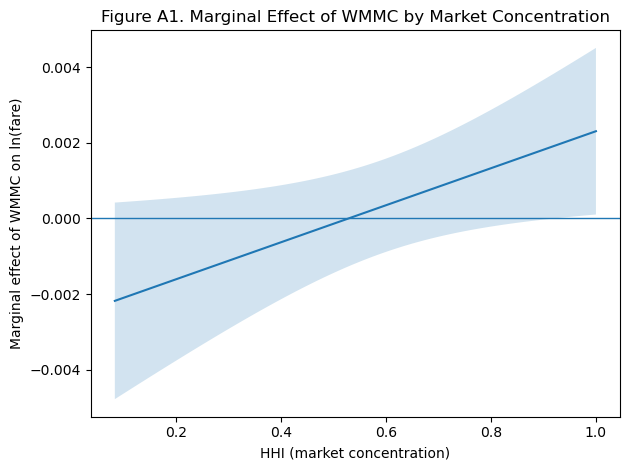

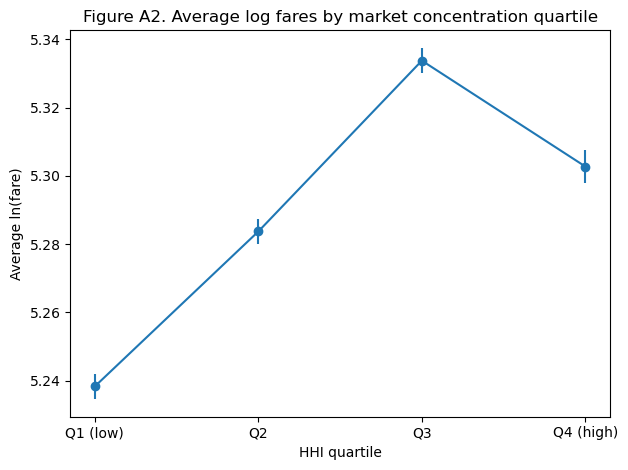

Saved: Figure_A1_marginal_effect.png, Figure_A2_avg_fare_by_quartile.png


In [34]:
# ============================================================
# Appendix Tables (A1–A3) + Figures (A1–A2)
# from linearmodels PanelOLS results objects
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# Helpers
# ----------------------------
def star(p):
    if p < 0.01: return "***"
    if p < 0.05: return "**"
    if p < 0.10: return "*"
    return ""

def coef_se_str(res, var):
    b = float(res.params[var])
    se = float(res.std_errors[var])
    p = float(res.pvalues[var])
    return f"{b:.4f}{star(p)}", f"({se:.4f})"

def get_n(res):
    # linearmodels has nobs
    return int(getattr(res, "nobs", np.nan))

def get_fe_flags(res):
    # included effects printed in summary; we’ll just hardcode since you used entity+time everywhere
    return "Yes", "Yes"

def get_cluster_note(cluster_type):
    return "Market" if cluster_type == "market" else "Carrier×Market (entity)"

def reg_table(res_list, col_names, vars_order, extra_rows=None, title=None):
    """
    Build a simple “coef row + se row” regression table as a DataFrame.
    res_list: list of fitted results
    vars_order: list of variable names in desired order (must exist in each model or will be blank)
    extra_rows: list of (row_label, list_of_values_by_column)
    """
    rows = []
    idx = []

    # variable rows: coef then SE
    for v in vars_order:
        coef_row = []
        se_row = []
        for res in res_list:
            if v in res.params.index:
                c, s = coef_se_str(res, v)
            else:
                c, s = "", ""
            coef_row.append(c)
            se_row.append(s)
        idx.extend([v, ""])
        rows.extend([coef_row, se_row])

    # extras
    if extra_rows:
        for lbl, vals in extra_rows:
            idx.append(lbl)
            rows.append(vals)

    tab = pd.DataFrame(rows, index=idx, columns=col_names)
    if title:
        tab.attrs["title"] = title
    return tab

def save_table(tab: pd.DataFrame, basename: str):
    tab.to_csv(f"{basename}.csv")
    # Optional LaTeX export (basic)
    with open(f"{basename}.tex", "w", encoding="utf-8") as f:
        f.write(tab.to_latex(escape=False))

# ============================================================
# INPUT: plug in your fitted regression objects here
# ============================================================
# You likely have these objects already:
# - Baseline (A1 col 1): res_base_market or similar
# - Interaction main (A1 col 2/3): res_w_market (WMMC + HHI + interaction)
# - Discrete high-HHI: res_disc_market
# - Quartile bins: res_bins  (market-clustered)
#
# If names differ, just reassign below.
#
# Example expected objects (edit as needed):
# res_base_market = <PanelOLS fit>   # ln_fare ~ wmmc_seat_lag1, FE, market clustered
# res_w_market    = <PanelOLS fit>   # ln_fare ~ wmmc_seat_lag1 + hhi_seat + wmmc_x_hhi, FE, market clustered
# res_disc_market = <PanelOLS fit>   # ln_fare ~ wmmc_seat_lag1 + high_hhi + wmmc_x_highhhi, FE, market clustered
# res_bins        = <PanelOLS fit>   # ln_fare ~ wmmc + Q_2 Q_3 Q_4 + wmmc×Q’s, FE, market clustered

# ---- If you don't already have a market-clustered baseline, run it quickly (recommended):
# df_w must exist from earlier steps; else recreate it from your pipeline
try:
    from linearmodels.panel import PanelOLS
    # df_w should already include: ln_fare, wmmc_seat_lag1, hhi_seat, im, mkt, qtr_id
    # if not, rebuild df_w as you did earlier.
    d0 = df_w.dropna(subset=["wmmc_seat_lag1"]).copy()
    d0 = d0.set_index(["im","qtr_id"]).sort_index()
    res_base_market = PanelOLS(d0["ln_fare"], d0[["wmmc_seat_lag1"]],
                               entity_effects=True, time_effects=True
                              ).fit(cov_type="clustered", clusters=d0["mkt"])
except Exception as e:
    print("NOTE: Could not auto-create res_base_market. If you already have it, ignore this message.")
    print("Error:", e)

# ============================================================
# TABLE A1: Baseline + Interaction
# ============================================================
A1_models = [res_base_market, res_w_market]
A1_names  = ["(1) Baseline", "(2) +HHI & Interaction"]

A1_vars = ["wmmc_seat_lag1", "hhi_seat", "wmmc_x_hhi"]

A1_extra = [
    ("Carrier×Market FE", ["Yes", "Yes"]),
    ("Quarter FE",        ["Yes", "Yes"]),
    ("SE Clustering",     ["Market", "Market"]),
    ("Observations",      [str(get_n(res_base_market)), str(get_n(res_w_market))]),
]

tab_A1 = reg_table(A1_models, A1_names, A1_vars, extra_rows=A1_extra, title="Table A1")
save_table(tab_A1, "Table_A1_reg")

# ============================================================
# TABLE A2: Robustness – clustering + discrete high-HHI
# ============================================================
A2_models = [res_w_entity, res_w_market, res_disc_market]
A2_names  = ["(1) Cluster: entity", "(2) Cluster: market", "(3) High-HHI indicator"]

A2_vars = ["wmmc_seat_lag1", "hhi_seat", "wmmc_x_hhi", "high_hhi", "wmmc_x_highhhi"]

A2_extra = [
    ("Carrier×Market FE", ["Yes", "Yes", "Yes"]),
    ("Quarter FE",        ["Yes", "Yes", "Yes"]),
    ("SE Clustering",     ["Entity", "Market", "Market"]),
    ("Observations",      [str(get_n(res_w_entity)), str(get_n(res_w_market)), str(get_n(res_disc_market))]),
]

tab_A2 = reg_table(A2_models, A2_names, A2_vars, extra_rows=A2_extra, title="Table A2")
save_table(tab_A2, "Table_A2_robust")

# ============================================================
# TABLE A3: Quartile bins (levels + interactions)
# ============================================================
A3_models = [res_bins]
A3_names  = ["(1) HHI quartiles"]

# These are your variable names from the bins regression:
A3_vars = ["wmmc_seat_lag1", "Q_2", "Q_3", "Q_4", "wmmc_x_Q_2", "wmmc_x_Q_3", "wmmc_x_Q_4"]

A3_extra = [
    ("Carrier×Market FE", ["Yes"]),
    ("Quarter FE",        ["Yes"]),
    ("SE Clustering",     ["Market"]),
    ("Observations",      [str(get_n(res_bins))]),
]

tab_A3 = reg_table(A3_models, A3_names, A3_vars, extra_rows=A3_extra, title="Table A3")
save_table(tab_A3, "Table_A3_quartiles")

print("Saved: Table_A1_reg.(csv/tex), Table_A2_robust.(csv/tex), Table_A3_quartiles.(csv/tex)")

# ============================================================
# FIGURE A1: Marginal effect of WMMC by HHI (from continuous interaction model)
# ============================================================
# Uses market-clustered interaction model: res_w_market
b1 = float(res_w_market.params["wmmc_seat_lag1"])
b3 = float(res_w_market.params["wmmc_x_hhi"])

# variance of marginal effect: Var(b1 + h*b3) = Var(b1) + h^2 Var(b3) + 2h Cov(b1,b3)
vcv = res_w_market.cov
var_b1 = float(vcv.loc["wmmc_seat_lag1", "wmmc_seat_lag1"])
var_b3 = float(vcv.loc["wmmc_x_hhi", "wmmc_x_hhi"])
cov_13 = float(vcv.loc["wmmc_seat_lag1", "wmmc_x_hhi"])

h_grid = np.linspace(float(df_w["hhi_seat"].min()), float(df_w["hhi_seat"].max()), 200)
me = b1 + b3 * h_grid
se_me = np.sqrt(var_b1 + (h_grid**2) * var_b3 + 2 * h_grid * cov_13)

ci_lo = me - 1.96 * se_me
ci_hi = me + 1.96 * se_me

plt.figure()
plt.plot(h_grid, me)
plt.fill_between(h_grid, ci_lo, ci_hi, alpha=0.2)
plt.axhline(0, linewidth=1)
plt.xlabel("HHI (market concentration)")
plt.ylabel("Marginal effect of WMMC on ln(fare)")
plt.title("Figure A1. Marginal Effect of WMMC by Market Concentration")
plt.tight_layout()
plt.savefig("Figure_A1_marginal_effect.png", dpi=300)
plt.show()

# ============================================================
# FIGURE A2: Average ln_fare by HHI quartile (descriptive)
# ============================================================
# Use df_w (or df) with ln_fare and hhi_seat
df_fig = df_w.dropna(subset=["ln_fare", "hhi_seat"]).copy()

# quartiles (1-4)
df_fig["hhi_q"] = pd.qcut(df_fig["hhi_seat"], q=4, labels=[1,2,3,4], duplicates="drop").astype(int)

# mean and 95% CI (cluster-robust CI would be more complex; use simple SE of mean for descriptive figure)
g = df_fig.groupby("hhi_q")["ln_fare"]
mean_ln = g.mean()
se_ln = g.std() / np.sqrt(g.count())
ci_lo2 = mean_ln - 1.96 * se_ln
ci_hi2 = mean_ln + 1.96 * se_ln

plt.figure()
x = mean_ln.index.astype(int).to_numpy()
plt.plot(x, mean_ln.values, marker="o")
plt.vlines(x, ci_lo2.values, ci_hi2.values)
plt.xticks([1,2,3,4], ["Q1 (low)", "Q2", "Q3", "Q4 (high)"])
plt.xlabel("HHI quartile")
plt.ylabel("Average ln(fare)")
plt.title("Figure A2. Average log fares by market concentration quartile")
plt.tight_layout()
plt.savefig("Figure_A2_avg_fare_by_quartile.png", dpi=300)
plt.show()

print("Saved: Figure_A1_marginal_effect.png, Figure_A2_avg_fare_by_quartile.png")


In [38]:
import sys
!{sys.executable} -m pip install reportlab

   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.0 MB 640.0 kB/s eta 0:00:04
   - -------------------------------------- 0.1/2.0 MB 812.7 kB/s eta 0:00:03
   ---------- ----------------------------- 0.5/2.0 MB 4.6 MB/s eta 0:00:01
   ------------------------------- -------- 1.5/2.0 MB 9.8 MB/s eta 0:00:01
   ---------------------------------------  1.9/2.0 MB 10.3 MB/s eta 0:00:01
   ---------------------------------------- 2.0/2.0 MB 8.9 MB/s eta 0:00:00


In [39]:
import os
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas

# ----------------------------
# 1) Put your regression objects here
# ----------------------------
# A2: Robustness (you likely want both cluster schemes + discrete model)
#   - res_w_entity: WMMC + HHI + WMMC×HHI, clustered by entity
#   - res_w_market: WMMC + HHI + WMMC×HHI, clustered by market
#   - res_disc_market: WMMC + HighHHI + WMMC×HighHHI, clustered by market
A2_models = {
    "Table_A2_col1_WMMCxHHI_clusterEntity": res_w_entity,
    "Table_A2_col2_WMMCxHHI_clusterMarket": res_w_market,
    "Table_A2_col3_WMMCxHighHHI_clusterMarket": res_disc_market,
}

# A3: Quartile bins model (market clustered)
A3_models = {
    "Table_A3_col1_WMMCxHHI_quartiles_clusterMarket": res_bins,
}

# Output folder (change if you want)
OUTDIR = "appendix_outputs"
os.makedirs(OUTDIR, exist_ok=True)

# ----------------------------
# 2) Helpers: write TXT + PDF
# ----------------------------
def save_summary_txt(res, filepath_txt):
    txt = res.summary.as_text()
    with open(filepath_txt, "w", encoding="utf-8") as f:
        f.write(txt)
    return txt

def save_text_as_pdf(text, filepath_pdf, font_name="Courier", font_size=8.5,
                     left=40, top=750, line_height=10):
    """
    Writes monospaced text into a PDF. If it runs off the page, it continues on new pages.
    """
    c = canvas.Canvas(filepath_pdf, pagesize=letter)
    width, height = letter

    y = top
    c.setFont(font_name, font_size)

    for line in text.split("\n"):
        if y < 40:  # new page
            c.showPage()
            c.setFont(font_name, font_size)
            y = top
        c.drawString(left, y, line[:2000])  # defensive: avoid ultra-long lines
        y -= line_height

    c.save()

# ----------------------------
# 3) Export A2
# ----------------------------
for name, res in A2_models.items():
    txt_path = os.path.join(OUTDIR, f"{name}.txt")
    pdf_path = os.path.join(OUTDIR, f"{name}.pdf")

    txt = save_summary_txt(res, txt_path)
    save_text_as_pdf(txt, pdf_path)

print("Saved A2 summaries to:", OUTDIR)

# ----------------------------
# 4) Export A3
# ----------------------------
for name, res in A3_models.items():
    txt_path = os.path.join(OUTDIR, f"{name}.txt")
    pdf_path = os.path.join(OUTDIR, f"{name}.pdf")

    txt = save_summary_txt(res, txt_path)
    save_text_as_pdf(txt, pdf_path)

print("Saved A3 summaries to:", OUTDIR)

Saved A2 summaries to: appendix_outputs
Saved A3 summaries to: appendix_outputs


In [35]:
summary_txt = res_w_market.summary.as_text()

with open("Table_A1_PanelOLS.txt", "w", encoding="utf-8") as f:
    f.write(summary_txt)

print(summary_txt)

                          PanelOLS Estimation Summary                           
Dep. Variable:                ln_fare   R-squared:                        0.0022
Estimator:                   PanelOLS   R-squared (Between):              0.0136
No. Observations:              150483   R-squared (Within):               0.0029
Date:                Thu, Dec 25 2025   R-squared (Overall):              0.0123
Time:                        21:43:55   Log-likelihood                 6.487e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      93.348
Entities:                       20534   P-value                           0.0000
Avg Obs:                       7.3285   Distribution:                F(3,129925)
Min Obs:                       1.0000                                           
Max Obs:                       22.000   F-statistic (robust):             10.416
                            

In [ ]:
summary_txt = res_w_market.summary.as_text()

with open("Table_A1_PanelOLS.txt", "w", encoding="utf-8") as f:
    f.write(summary_txt)

print(summary_txt)

In [ ]:
summary_txt = res_w_market.summary.as_text()

with open("Table_A1_PanelOLS.txt", "w", encoding="utf-8") as f:
    f.write(summary_txt)

print(summary_txt)

In [36]:
latex_code = res_w_market.summary.as_latex()

with open("Table_A1_PanelOLS.tex", "w", encoding="utf-8") as f:
    f.write(latex_code)

print(latex_code)

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    &      ln\_fare      & \textbf{  R-squared:         }   &      0.0022      \\
\textbf{Estimator:}        &      PanelOLS      & \textbf{  R-squared (Between):}  &      0.0136      \\
\textbf{No. Observations:} &       150483       & \textbf{  R-squared (Within):}   &      0.0029      \\
\textbf{Date:}             &  Thu, Dec 25 2025  & \textbf{  R-squared (Overall):}  &      0.0123      \\
\textbf{Time:}             &      21:43:55      & \textbf{  Log-likelihood     }   &    6.487e+04     \\
\textbf{Cov. Estimator:}   &     Clustered      & \textbf{                     }   &                  \\
\textbf{}                  &                    & \textbf{  F-statistic:       }   &      93.348      \\
\textbf{Entities:}         &       20534        & \textbf{  P-value            }   &      0.0000      \\
\textbf{Avg Obs:}          &       7.3285       & \textbf{  Distribution:      }   &   F(3,129925)    \\
\textbf{M